### Chelsea Seydlitz
Lab7&8  
Lab Partner: Michael Wang

## Lab 7 Setup

In [279]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats,signal
from scipy.optimize import curve_fit
from scipy.special import factorial
from sklearn import preprocessing

# Preparing Higgs Data
higg = open ("higgs_100000_pt_1000_1200.pkl",'rb')
higgD = pickle.load(higg)

# Preparing QCD Data
qcd = open ("qcd_100000_pt_1000_1200.pkl",'rb')
qcdD = pickle.load(qcd)

higgs_qcd_stuff = {
    "PT" : {
        "higgs_detail": {
            "legend_label":"Higgs Particle",
            "data": higgD['pt']       
        },
        "qcd_detail": {
            "legend_label":"QCD Background",
            "data": qcdD['pt']
        },
        "title":"Angular Momentum",
        "xlabel":"pt(GeV)",
    },
    "ETA": {
        "higgs_detail": {
            "legend_label":"Higgs Particle",
            "data": higgD['eta']       
        },
        "qcd_detail": {
            "legend_label":"QCD Background",
            "data": qcdD['eta']
        },
        "title":"Pseudorapidity",
        "xlabel":"n (-Pi to Pi)",
    },
    "PHI": {
        "higgs_detail": {
            "legend_label":"Higgs Particle",
            "data": higgD['phi']
            
        },
        "qcd_detail": {
            "legend_label":"QCD Background",
            "data": qcdD['phi']
        },
        "title":"Azimuthal Angle",
        "xlabel":"n (-Pi to Pi)",
    },
    "MASS": {
        "higgs_detail": {
            "legend_label":"Higgs Particle",
            "data": higgD['mass']
            
        },
        "qcd_detail": {
            "legend_label":"QCD Background",
            "data": qcdD['mass']
        },
        "title":"Mass",
        "xlabel":"Mass (GeV)",
    },
    "EE2": {
        "higgs_detail": {
            "legend_label":"Higgs Particle",
            "data": higgD['ee2']
            
        },
        "qcd_detail": {
            "legend_label":"QCD Background",
            "data": qcdD['ee2']
        },
        "title":"2-Point ECF Ratio"
    },
    "EE3": {
        "higgs_detail": {
            "legend_label":"Higgs Particle",
            "data": higgD['ee3']
            
        },
        "qcd_detail": {
            "legend_label":"QCD Background",
            "data": qcdD['ee3']
        },
        "title":"3-Point ECF Ratio"
    },
    "D2": {
        "higgs_detail": {
            "legend_label":"Higgs Particle",
            "data":higgD['d2']     
        },
        "qcd_detail": {
            "legend_label":"QCD Background",
            "data":qcdD['d2']
        },
        "title":"3-to-2 Point ECF Ratio"
    },
    "ANG": {
        "higgs_detail": {
            "legend_label":"Higgs Particle",
            "data":higgD['angularity']
            
        },
        "qcd_detail": {
            "legend_label":"QCD Background",
            "data":qcdD['angularity']
        },
        "title":"Angularity",
        "xlabel":"Angularity (tau_a)",
    },
    "T1": {
        "higgs_detail": {
            "legend_label":"Higgs Particle",
            "data":higgD['t1']   
        },
        "qcd_detail": {
            "legend_label":"QCD Background",
            "data":qcdD['t1']
        },
        "title":"Subjettiness - tau1"
    },
    "T2": {
        "higgs_detail": {
            "legend_label":"Higgs Particle",
            "data":higgD['t2']
        },
        "qcd_detail": {
            "legend_label":"QCD Background",
            "data":qcdD['t2']
        },
        "title":"Subjettiness - tau2"
    },
    "T3": {
        "higgs_detail": {
            "legend_label":"Higgs Particle",
            "data":higgD['t3']
        },
        "qcd_detail": {
            "legend_label":"QCD Background",
            "data":qcdD['t3']
        },
        "title":"Subjettiness - tau3"
    },
    "T21": {
        "higgs_detail": {
            "legend_label":"Higgs Particle",
            "data":higgD['t21']
        },
        "qcd_detail": {
            "legend_label":"QCD Background",
            "data":qcdD['t21']
        },
        "title":"Subjettiness - tau21"
    },
    "T32": {
        "higgs_detail": {
            "legend_label":"Higgs Particle",
            "data":higgD['t32']    
        },
        "qcd_detail": {
            "legend_label":"QCD Background",
            "data":qcdD['t32']
        },
        "title":"Subjettiness - tau32"
    },
    "KTDR": {
        "higgs_detail": {
            "legend_label":"Higgs Particle",
            "data":higgD['KtDeltaR']
        },
        "qcd_detail": {
            "legend_label":"QCD Background",
            "data":qcdD['KtDeltaR']
        },
        "title":"KtDeltaR"
    }
}

features_list = ['PT','ETA','PHI','MASS','EE2','EE3','D2','ANG','T1','T2','T3','T21','T32','KTDR']

In [280]:
"""This pair of methods will evaluate the significance of a given threshold for data selections"""

def eval_and_print(thresh_details):
    """Accepts dictionary of details related to the threshold
    Find the significance for Higgs Count and QCD Count (with normalizing factors 50 and 2000).
    Then prints significance based on the thresholds given"""
    
    numerator = 50*(thresh_details['hc']/100000)
    denominator = np.sqrt(2000*(thresh_details['qc']/100000))
    significance = numerator/denominator
         
    print(f"The significance if you use a threshold from {thresh_details['low_lim']}"
          f" to {thresh_details['high_lim']} on the {thresh_details['feature']} feature is: {significance}")
    
def count_in_threshold(low_lim, high_lim, feature, print_evaluation=True):
    """Must provide low limit, high limit, and the feature which you are evaluating
    Also accepts a boolean value to continue to print the significance. 
    Setting this to False will only provide a higgs and qcd background count
    
    Given the limits provided, counts how many background and 
    higgs particles remain after applying threshold limits.
    Passes counts to eval_and_print to be evaluated and printed"""

    # Start counts at 1 because indexing goes from 0-99999, 
    # which means if we start the count at 0 we will always be one short
    higgs_count=1
    qcd_count=1
    for hval,qval in zip(
        higgs_qcd_stuff[feature]['higgs_detail']['data'],
        higgs_qcd_stuff[feature]['qcd_detail']['data']):
        if low_lim <= hval <= high_lim:
            higgs_count+=1
        if low_lim <= qval <= high_lim:
            qcd_count+=1
    threshold_details = {
        "low_lim":low_lim,
        "high_lim":high_lim,
        "hc":higgs_count,
        "qc":qcd_count,
        "feature":higgs_qcd_stuff[feature]['title']
    }
    if print_evaluation:
        eval_and_print(threshold_details)    

In [281]:
def select_indexes(low_lim,high_lim,feature):
    """Must provide a low limit, high limit, and the feature which you are evaluating.
    Returns lists of indexes which are within the threshold"""
    
    indexes = []
    feature_list = list(feature)
    
    for qval in feature_list:
        if low_lim <= qval <= high_lim:
            indexes.append(feature_list.index(qval))
            
    return indexes

## Intro
In this part of the lab, I will use the selection of data with a pT range of 1000-1200

## Problem 1

Below is a stacked histogram of QCD background mass and optimized mass, both log-scale and non-log-scale. This visualization will be useful when we optimize our data.

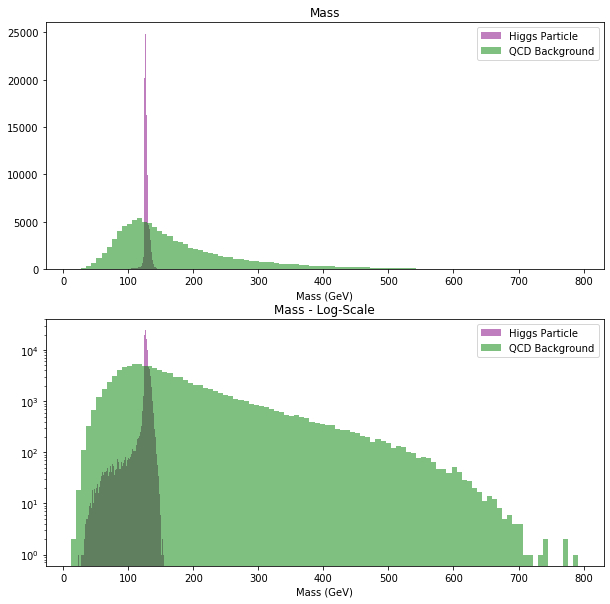

In [282]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))

for i in range(0,2):
    ax[i].hist(
        higgs_qcd_stuff['MASS']['higgs_detail']['data'],
        bins=100,
        color='purple',
        alpha=0.5,
        label='Higgs Particle')
    ax[i].hist(
        higgs_qcd_stuff['MASS']['qcd_detail']['data'],
        bins=100,
        color='green',
        alpha=0.5,
        label='QCD Background')
    ax[i].legend(loc='upper right')
    ax[i].set_xlabel("Mass (GeV)")

# Graph details that differ between log and non-log scale visualizations
ax[0].set_title(higgs_qcd_stuff['MASS']['title'])
ax[1].set_title(f"{higgs_qcd_stuff['MASS']['title']} - Log-Scale")
ax[1].set_yscale('log')

plt.show()

### We Ask the Question:
Without first optimizing data, how does the value of $\frac{N_{higgs}}{\sqrt{N_{QCD}}}$, which closely estimates significance, compare to the significance obtained by a best-fit distribution?

### Why we Ask this Question:
If $\frac{N_{higgs}}{\sqrt{N_{QCD}}}$ can be maximized closer to the expected significance given by a best-fit line, we can use it to quickly calculate significance after making strategic cuts to features which will minimize background and maximize Higgs signal.  

### Graphing The Best Fit Line
Below we graph the best-fit Poisson distribution whose mean is the same as that of our background data: 

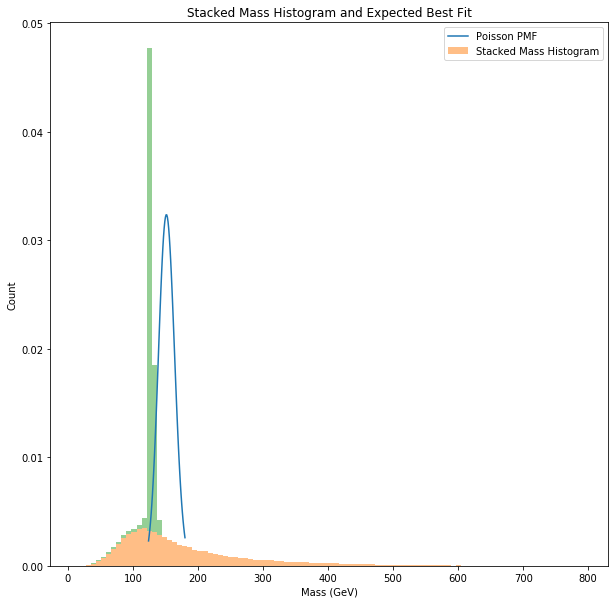

In [340]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

# Make Poisson representation with the mean of our background data
qcdMu = np.mean(higgs_qcd_stuff['MASS']['qcd_detail']['data'])
higgsMu = np.mean(higgs_qcd_stuff['MASS']['higgs_detail']['data'])
mu = ((qcdMu+higgsMu)/2)
x = np.arange(stats.poisson.ppf(0.01, mu=mu),stats.poisson.ppf(0.99, mu=mu))

# Prepare the best-fit distribution
ax.plot(
    x, 
    stats.poisson.pmf(x, mu=mu), 
    ms=4, 
    label='Poisson PMF')

# Prepare background data
ax.hist([higgs_qcd_stuff['MASS']['qcd_detail']['data'],higgs_qcd_stuff['MASS']['higgs_detail']['data']],
        bins=100,
        stacked=True,
        alpha=0.5, 
        label='Stacked Mass Histogram', 
        density=True)

# Set graph details
ax.legend(loc='upper right')
ax.set_title("Stacked Mass Histogram and Expected Best Fit")
ax.set_ylabel("Count")
ax.set_xlabel("Mass (GeV)")

plt.show()

With the above code, we know that the mean of our background, and what should be the mean of our Poisson best-fit distribution is 151.96 (the value of the variable mu).

We will now find and compare our significance to  $\frac{N_{higgs}}{\sqrt{N_{QCD}}}$

In [369]:
cdf = stats.poisson.cdf(151.96,mu=125)
sig = stats.norm.ppf(cdf)
signif = 50/np.sqrt(2000)
print(f"Best-Fit Significance: {sig}")
print(f"Actual Significance: {signif}")

Best-Fit Significance: 2.3075513973236887
Actual Significance: 1.118033988749895


These values are not the same, but they are both very low (if we consider 5$\sigma$ to be a high, good significance). We will need to optimize our data so that this number higher, that way we can claim a 'significant discovery'

#### Problem 2

### We Ask the Question:
What threshold values would best optimize our background so that we can keep the maximum good data and also the minimum background data?

### Why We Ask this Question:
We have already established that there is an astounding amount of background noise that will always cause inacurate experiement outcomes. So, we need to be able to cut the data at such a point that gives us the best possible significance (as compared to the expected significance).

### Method Moving Forward
We will use $\frac{N_{higgs}}{\sqrt{N_{QCD}}}$ to test our thresholds. 

First, we will identify a few thresholds which appear significant and should be part of our tests:
* Min/Max values
    * Chosen because these are the start and end of the entire array of data
* 100/150 
    * 100 appears to be where the data begins to be spiking upward
    * 140 appears to be where the data falls off sharply 
* 124/128
    * Arbitrary thresholds

Ideally, we want to keep any thresholds whose significance far greater than the significance found with $\frac{N_{higgs}}{\sqrt{N_{QCD}}}$: 1.118    

We will calculate $\frac{N_{higgs}}{\sqrt{N_{QCD}}}$ frequently in order to gauge if we've cut too much good data or not. 

### Actually Moving Forward
First, we will start with the mass:

In [286]:
# Lists of high and low thresholds, respecitvely 
xlow = [min(round(higgs_qcd_stuff['MASS']['higgs_detail']['data'])),100,124]
xhigh = [max(round(higgs_qcd_stuff['MASS']['higgs_detail']['data'])),150,128]
    
for i in range(0,len(xlow)):
    count_in_threshold(xlow[i], xhigh[i],'MASS')

The significance if you use a threshold from 23.0 to 155.0 on the Mass feature is: 1.5300467864859666
The significance if you use a threshold from 100 to 150 on the Mass feature is: 1.95911751841519
The significance if you use a threshold from 124 to 128 on the Mass feature is: 4.164727780077581


### Conclusion
So, obviously we just want to use the threshold which maximizes the significance. In the above, our threshold will be 124-128. Keep in mind that this is significance ONLY for the mass feature, and not all data together. While the significance does seem high here, it will be considerably lower once applied to the total data.  

My lab partner chose a very similar threshold with their data (low pT). They chose the threshold to be 124-127, which produced a significance of 3.13. 

## Problem 3
We want to have visualizations of all of our features.

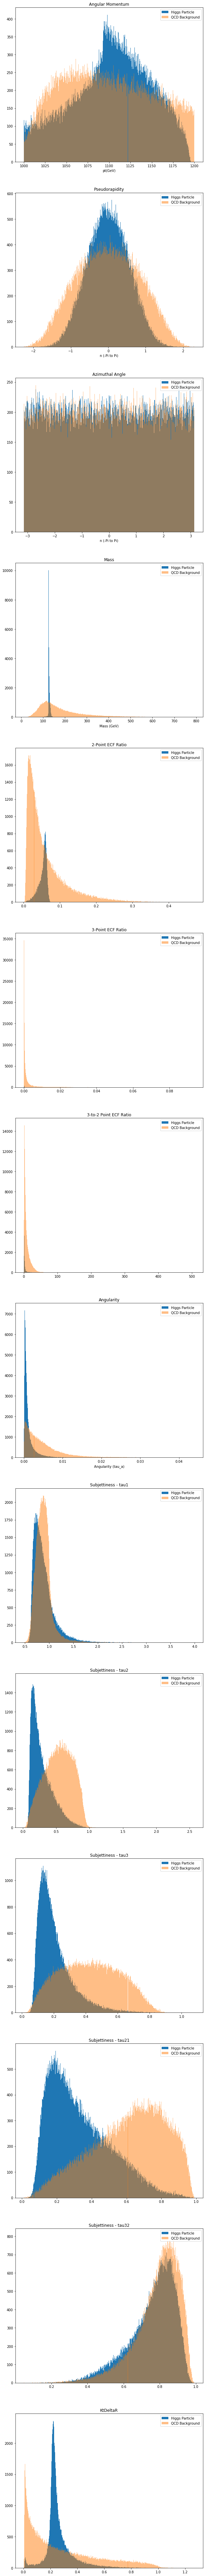

In [287]:
fig,ax=plt.subplots(14, 1, figsize=(10,140))

for i in range(len(features_list)):
    # Creating a histogram of Higgs data
    ax[i].hist(
        higgs_qcd_stuff.get(features_list[i]).get('higgs_detail').get('data',""),
        500,
        label=higgs_qcd_stuff.get(features_list[i]).get('higgs_detail').get('legend_label',""))
    # Creating a histogram of QCD data
    ax[i].hist(
        higgs_qcd_stuff.get(features_list[i]).get('qcd_detail').get('data',""),
        500,
        alpha=.5,
        label=higgs_qcd_stuff.get(features_list[i]).get('qcd_detail').get('legend_label',""))
    # Setting graph details that are not sensitive to data source
    ax[i].set_title(higgs_qcd_stuff.get(features_list[i]).get('title',""))
    ax[i].set_xlabel(higgs_qcd_stuff.get(features_list[i]).get('xlabel',""))
    ax[i].legend(loc='upper right')
    
plt.show() 
    
    

At this point, I would like to only optimize with mass, and see what the graphs show me after this cut to make any other cuts 
    
### Optimizing with Mass
With the thresholds we ultimately found to be the best in Problem 2, we will now extract the data that we want from all features. First, we find the indexes of data kept. 

In [288]:
# Get the indexes of the values we want to retain using the method select_indexes
qcd_feature = higgs_qcd_stuff['MASS']['qcd_detail']['data']
qcd_mass_indexes = select_indexes(124,126,qcd_feature)

h_feature = higgs_qcd_stuff['MASS']['higgs_detail']['data']
h_mass_indexes = select_indexes(124,126,h_feature)

Now that we have the indexes, we will need to pull out the data we want to keep, and multiply each by the expected counts. 

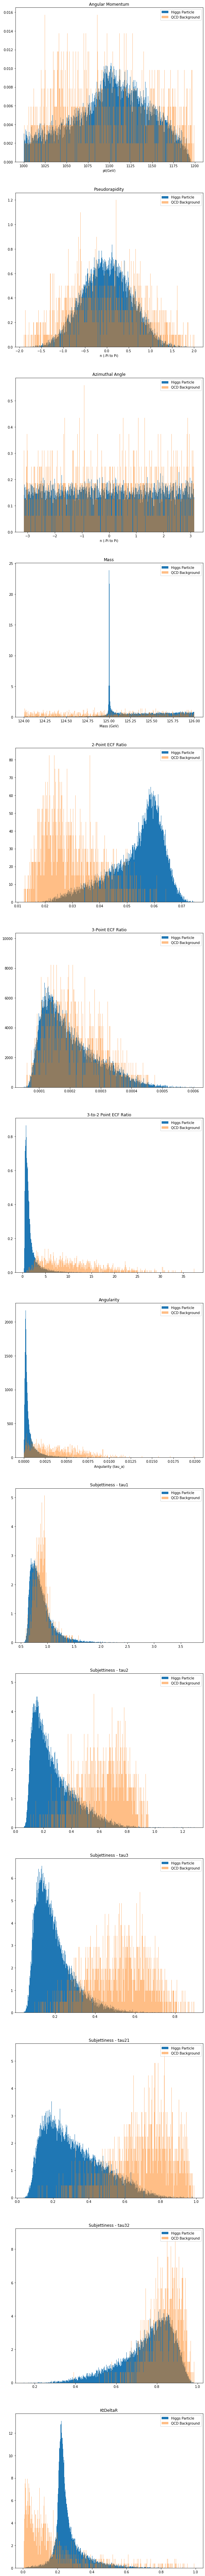

In [289]:
fig,ax=plt.subplots(14, 1, figsize=(10,140))

for i in range(len(features_list)):
    qcd_optimized_mass = []
    for ind in qcd_mass_indexes:
        qcd_optimized_mass.append((higgs_qcd_stuff.get(features_list[i]).get('qcd_detail').get('data',""))[ind])
        
    higgs_optimized_mass = []
    for ind in h_mass_indexes:
        higgs_optimized_mass.append((higgs_qcd_stuff.get(features_list[i]).get('higgs_detail').get('data',""))[ind])
        
    # Creating a histogram of QCD data 
    ax[i].hist(
        higgs_optimized_mass,
        500,
        density=True,
        label=higgs_qcd_stuff.get(features_list[i]).get('higgs_detail').get('legend_label','')) 
    ax[i].hist(
        qcd_optimized_mass,
        500,
        density=True,
        alpha=.5,
        label=higgs_qcd_stuff.get(features_list[i]).get('qcd_detail').get('legend_label','')) 
    # Setting graph details that are not sensitive to data source
    ax[i].set_title(higgs_qcd_stuff.get(features_list[i]).get('title',''))  
    ax[i].set_xlabel(higgs_qcd_stuff.get(features_list[i]).get('xlabel',''))
    ax[i].legend(loc='upper right')
    
plt.show() 
    

### Further Optimizations: 
The following features could be used to identify further cuts:

* **Angularity** 
    * Chosen because of the clear peak the Higgs data has over the QCD background data. In addition, there are useful data in regards to decays given an upper and lower bound in the Higgs distribution.
* **$\tau$21** 
    * Is a suggested excellent jet discriminator between background and boosted object jets. This suggestion is validated based on the comparison between $\tau$21 and $\tau$32

### Moving Forward
We can find now what our  $\frac{N_{higgs}}{\sqrt{N_{QCD}}}$ ratio is after the mass cut. 
The lenghth of the lists that we used to plot these graphs will give us the counts for what we kept. 

In [290]:
print(f"Number of higgs:{len(h_mass_indexes)}\n Number of QCD Background:{len(qcd_mass_indexes)}")

Number of higgs:28175
 Number of QCD Background:1280


In [291]:
numerator = 50*(len(h_mass_indexes)/100000)
denominator = np.sqrt(2000*(len(qcd_mass_indexes)/100000))
significance = numerator/denominator
print(significance)

2.7842866586013777


So now our $\frac{N_{higgs}}{\sqrt{N_{QCD}}}$ value equals:  
2.784

### Making Better Optimizations
A significance of 2.784 is not ideal. Let's explore using further cuts to remove noise from the data. 

I will now use the following optimizations (based on decisions made earlier, and in prior labs):  
* Angularity, with thresholds from 0-.003
    * Chosen based on the above optimized background plots   
* Tau21, with thresholds from 0-.7
    * Chosen based on the above optimized background plots

These estimates are based on the above preliminary optimizations.

In [307]:
count_in_threshold(0,.003,'ANG')
count_in_threshold(0,.7,'T21')

The significance if you use a threshold from 0 to 0.003 on the Angularity feature is: 1.5220734785480845
The significance if you use a threshold from 0 to 0.7 on the Subjettiness - tau21 feature is: 1.3750489849211387


## Problem 4   
### We Ask the Question:
Can we further optimize our data by including purposefully chosen thresholds on other features, and applying these constraints to the rest of the data?

### Why We Ask This:
We now want to see if the significance obtained by combining all thresholds together will be better than what we received simply from mass. The better we optimize the data (and the more noise we can remove), the more likely we are to detect a signal we're hunting for.    

### Method Forward
First, we will obtain a list of the features' indexes which fall within their respective thresholds.   
Then, we will create master lists of Higgs and QCD data separately.   
We will then uniquify those lists in order to have a list of indexes that are included in all thresholds together.  
That will get us counts for NHiggs and NQCD given our thresholds. From there we can use $\frac{N_{higgs}}{\sqrt{N_{QCD}}}$ to find significance again. If this value is larger than what we got with just the mass cuts, then we know that we succeeded in optimizing further. 

In [308]:
# Get the indexes of the values we want to retain
qcd_angularity_feature = []
for ind in qcd_mass_indexes:
    qcd_angularity_feature.append((higgs_qcd_stuff.get('ANG').get('qcd_detail').get('data',""))[ind])
        
qcd_t1_feature = []
for ind in qcd_mass_indexes:
    qcd_t1_feature.append((higgs_qcd_stuff.get('T21').get('qcd_detail').get('data',""))[ind])

higgs_angularity_feature = []
for ind in h_mass_indexes:
    higgs_angularity_feature.append((higgs_qcd_stuff.get('ANG').get('higgs_detail').get('data',""))[ind])
        
higgs_t1_feature = []
for ind in h_mass_indexes:
    higgs_t1_feature.append((higgs_qcd_stuff.get('T21').get('higgs_detail').get('data',""))[ind])

qcd_angularity_indexes = select_indexes(0,.003,qcd_angularity_feature)
qcd_tau_indexes = select_indexes(0,.7,qcd_t1_feature)
h_angularity_indexes = select_indexes(0,.003,higgs_angularity_feature)
h_tau_indexes = select_indexes(0,.7,higgs_t1_feature)

In [309]:
# Creating and uniquifying the master lists to use for significance, and graphing
qcd_master_list = []
higgs_master_list = []
qcd_master_list.extend(qcd_mass_indexes)
qcd_master_list.extend(qcd_angularity_indexes)
qcd_master_list.extend(qcd_tau_indexes)
higgs_master_list.extend(h_mass_indexes)
higgs_master_list.extend(h_angularity_indexes)
higgs_master_list.extend(h_tau_indexes)
qcd_unique_indexes = list(set(qcd_master_list))
higgs_unique_indexes = list(set(higgs_master_list))

# Find significance
numerator = 50*(len(higgs_unique_indexes)/100000)
denominator = np.sqrt(2000*(len(qcd_unique_indexes)/100000))
significance = numerator/denominator
         
print(f"The significance after applying ideal thresholds to Mass, Angularity, and Tau21"
        f" subjettiness features is: {significance}")



The significance after applying ideal thresholds to Mass, Angularity, and Tau21 subjettiness features is: 3.708614942122002


### Quantitative Results
We got a significance of 3.708 when taking Angularity, $\tau$21 Subjettiness, and Mass all into consideration.   
Initially, with only mass, we got significance = 2.78.  

This is much closer to our expected significance of 4.07, as obtained with the Poisson best-fit line in Lab 7.  

With the addition of Angularity and Subjettiness, we did increase the significance, therefore we can confidently say that our extra cuts were an improvement. 


### Qualitative Results  
Let us now explore the effect that our new cuts have on our visualizations. This will show us if the extra cuts made removed too much good data.

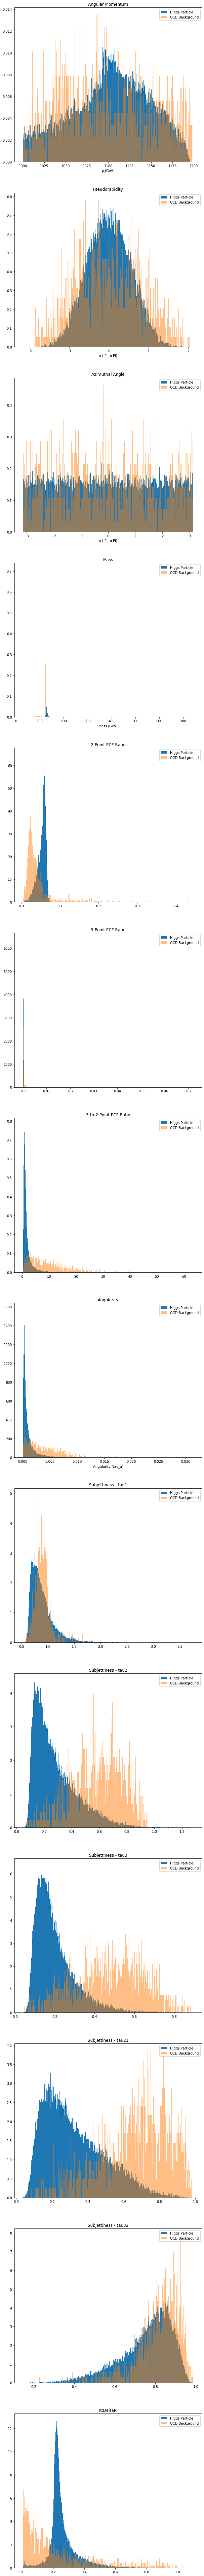

In [295]:
fig,ax=plt.subplots(14, 1, figsize=(10,140))

for i in range(len(features_list)):
    qcd_optimized_fin = []
    for j in qcd_unique_indexes:
        qcd_optimized_fin.append((higgs_qcd_stuff.get(features_list[i]).get('qcd_detail').get('data',""))[j])
        
    higgs_optimized_fin = []
    for ind in higgs_unique_indexes:
        higgs_optimized_fin.append((higgs_qcd_stuff.get(features_list[i]).get('higgs_detail').get('data',""))[ind])
        
    # Creating a histogram of Higgs data 
    ax[i].hist(
        higgs_optimized_fin,
        500,
        density=True,
        label=higgs_qcd_stuff.get(features_list[i]).get('higgs_detail').get('legend_label','')) 
    # Creating a histogram of QCD data
    ax[i].hist(
        qcd_optimized_fin,
        500,
        density=True,
        alpha=.5,
        label=higgs_qcd_stuff.get(features_list[i]).get('qcd_detail').get('legend_label',''))  
    # Setting graph details that are not sensitive to data source
    ax[i].set_title(higgs_qcd_stuff.get(features_list[i]).get('title',''))  
    ax[i].set_xlabel(higgs_qcd_stuff.get(features_list[i]).get('xlabel',''))
    ax[i].legend(loc='upper right')
    
plt.show() 

## Lab 7 Conclusion  
We can certainly see an improvement in the mass plot; there is far less noise on the left side of the peak than before when we removed just mass thresholds. 

Cuts with Angularity, Tau21 Subjettiness, and Mass got us a significance of 3.7 which is a fairly decent significance. Our next steps will identify if this is sufficient to pull a desirable signal out of data. 

So now let us say that our expected significance, moving forward, is 3.7.

Moving forward into Lab 8, I will use all three feature cuts to optimize the data. 

# Lab 8 Setup

In [296]:
import h5py

P1 = h5py.File('data_highLumi_pt_1000_1200.h5', 'r')
highLum = np.array(P1.get('data/block0_values'))
P1.close()

P2 = h5py.File('data_lowLumi_pt_1000_1200.h5', 'r')
lowLum = np.array(P2.get('data/block0_values'))
P2.close()

## High-Luminosity Data

Below are the histogram visualizations of of the high-luminosity data which we will be hunting for our signal in. It has been graphed on the same plot as our expected signal and background. 

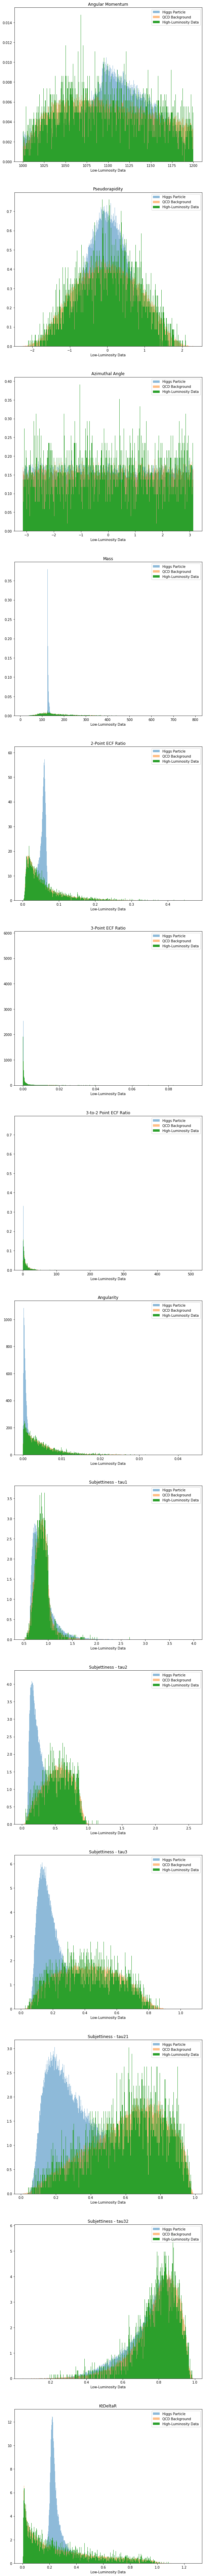

In [297]:
fig,ax=plt.subplots(14, 1, figsize=(10,140))

for i in range(0,14):
    ax[i].hist(
        higgs_qcd_stuff.get(features_list[i]).get('higgs_detail').get('data',""),
        500,
        alpha=.5,
        density=True,
        label=higgs_qcd_stuff.get(features_list[i]).get('higgs_detail').get('legend_label',""))
    # Creating a histogram of QCD data
    ax[i].hist(
        higgs_qcd_stuff.get(features_list[i]).get('qcd_detail').get('data',""),
        500,
        alpha=.5,
        density=True,
        label=higgs_qcd_stuff.get(features_list[i]).get('qcd_detail').get('legend_label',""))
    ax[i].hist(highLum[:,i],
        bins=500,
        density=True,
        label="High-Luminosity Data" )
    # Setting graph details that are not sensitive to data source
    ax[i].set_title(higgs_qcd_stuff.get(features_list[i]).get('title',''))  
    ax[i].set_xlabel("Low-Luminosity Data")
    ax[i].legend(loc='upper right')
    
plt.show()

### Optimizing the Data
I will now go through and follow the same process as before:  
* Find the indexes between the values that we want to keep  
    * Angularity: 0-.003
    * Tau21 Subjettiness: 0-.7
    * Mass: 124-128
* Make unique lists of those indexes  
* Remove keep desired values at those indexes; remove all others 
* Plot, find significance

### Finding the Significance
We will once again assume a Poisson distribution much like we did in Lab 7.   
We cannot use $\frac{N_{higgs}}{\sqrt{N_{QCD}}}$, however. The data we are using this time is not split between the background and the signal, so we do not know what NHiggs and NQCD are.  
We will use the mass data, with all cuts applied, find the mean, and calculate the significance from that. 

### Finding the Desired Indexes:

In [310]:
# Get the data for the features we want
hl_mass_feature_raw = highLum[:,3]
hl_tau21_feature_raw = highLum[:,11]
hl_ang_feature_raw = highLum[:,7]

# Select the indexes we want to keep 
hl_mass_indexes = select_indexes(124,128,hl_mass_feature_raw)

# Optimize all on mass first
hl_tau21_feature_optimized = []
hl_ang_feature_optimized = []
for ind in hl_mass_indexes:
    hl_tau21_feature_optimized.append(hl_tau21_feature_raw[ind])
    hl_ang_feature_optimized.append(hl_ang_feature_raw[ind])

# Get indexes of remaining features we want to keep 
hl_anularity_indexes = select_indexes(0,.003,hl_ang_feature_optimized)
hl_tau_indexes = select_indexes(0,.7,hl_tau21_feature_optimized) 

In [316]:
# Creating and uniquifying the master lists to use for significance and graphing
hl_master_list = []

hl_master_list.extend(hl_angularity_indexes)
hl_master_list.extend(hl_tau_indexes)
hl_master_list.extend(hl_mass_indexes)
hl_unique_indexes = list(set(hl_master_list))

### Visualizing the Optimized Data
Below we will graph the observed data and the expected signal and background on the same plots with the optimized cuts. 


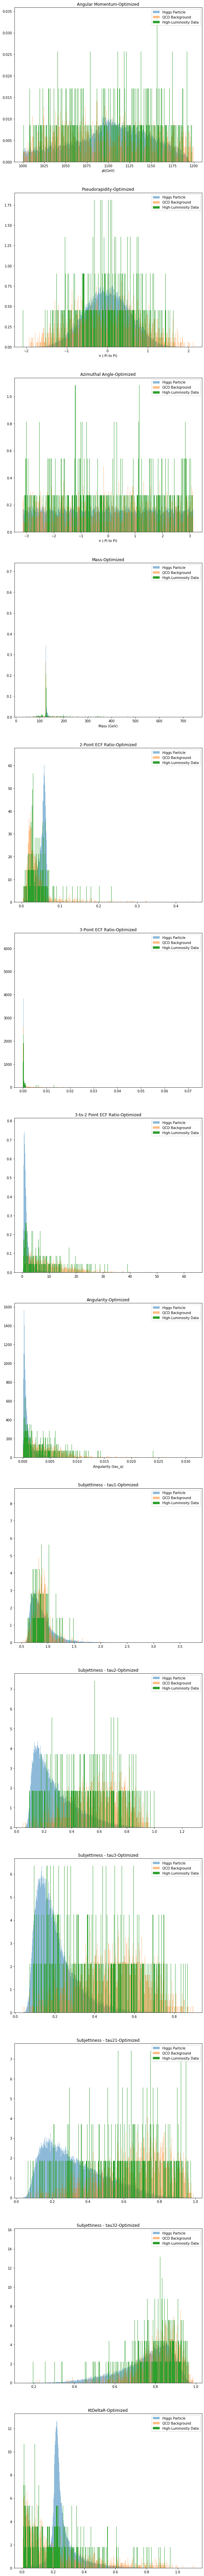

In [312]:
fig,ax=plt.subplots(14, 1, figsize=(10,140))

for k in range(0,14):
    hl_optimized_fin = []
    for l in hl_unique_indexes:
        hl_optimized_fin.append(highLum[:,k][l])
    
    qcd_optimized_fin = []
    for m in qcd_unique_indexes:
        qcd_optimized_fin.append((higgs_qcd_stuff.get(features_list[k]).get('qcd_detail').get('data',""))[m])
        
    higgs_optimized_fin = []
    for n in higgs_unique_indexes:
        higgs_optimized_fin.append((higgs_qcd_stuff.get(features_list[k]).get('higgs_detail').get('data',""))[n])
        
    # Creating a histogram of Higgs data 
    ax[k].hist(
        higgs_optimized_fin,
        500,
        alpha=.5,
        density=True,
        label=higgs_qcd_stuff.get(features_list[k]).get('higgs_detail').get('legend_label','')) 
    # Creating a histogram of QCD data
    ax[k].hist(
        qcd_optimized_fin,
        500,
        alpha=.5,
        density=True,
        label=higgs_qcd_stuff.get(features_list[k]).get('qcd_detail').get('legend_label',''))  
    # Creating a histogram of Observed data
    ax[k].hist(
        hl_optimized_fin,
        500,
        density=True,
        label="High-Luminosity Data"
        )  

    ax[k].set_title(f"{higgs_qcd_stuff.get(features_list[k]).get('title','')}-Optimized")  
    ax[k].set_xlabel(higgs_qcd_stuff.get(features_list[k]).get('xlabel',''))
    ax[k].legend(loc='upper right')
    
plt.show() 

### Finding the Significance  

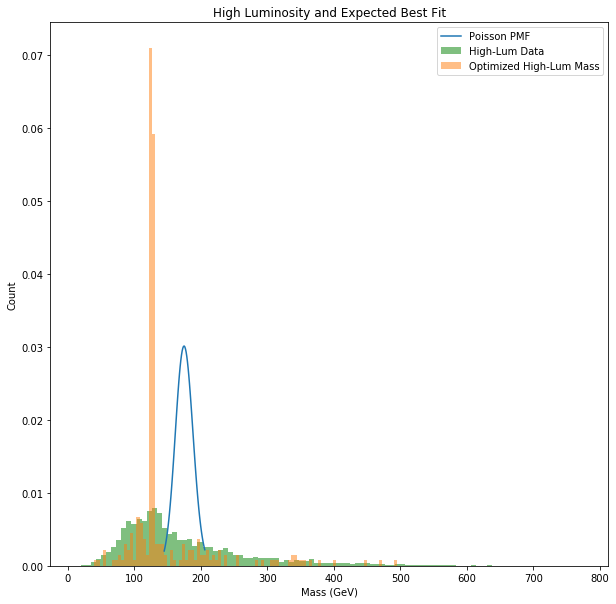

In [373]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

# Make Poisson representation with the mean of our background data
hl_optimized_mass_2 = []
for j in hl_unique_indexes:
    hl_optimized_mass_2.append(highLum[:,3][j])
qcdMu = np.mean(highLum[:,3])
x = np.arange(stats.poisson.ppf(0.01, mu=qcdMu),stats.poisson.ppf(0.99, mu=qcdMu))
# Prepare the best-fit distribution
ax.plot(
    x, 
    stats.poisson.pmf(x, mu=qcdMu), 
    ms=4,
    label='Poisson PMF')

# Prepare background data
ax.hist(highLum[:,3],
        bins=100,
        color='green',
        alpha=0.5, 
        label='High-Lum Data', 
        density=True)
ax.hist(hl_optimized_mass_2,
       bins=100,
       alpha=.5,
       label="Optimized High-Lum Mass",
       density=True)
# Set graph details
ax.legend(loc='upper right')
ax.set_title("High Luminosity and Expected Best Fit")
ax.set_ylabel("Count")
ax.set_xlabel("Mass (GeV)")

plt.show()

In [375]:
cdf_mean = stats.poisson.cdf(qcdMu,mu=125)
sig_mean = stats.norm.ppf(cdf_mean)

print(f"Significance: {sig_mean}")

Significance: 4.2688409469829365


### Conclusion
Significance with cuts: 4.26  
Expected significance: 3.7 

The significance was quite close to a 5$\sigma$ significance, which is much different than our expected significance.   
My suspicion is that there were far fewer Nhiggs and NQCD in the High Luminosity dataset, and so just a few more NQCD removed made a large difference. 

## Low-Luminosity Data
Below are the histogram visualizations of the low-luminosity data in which we will be hunting for our data.

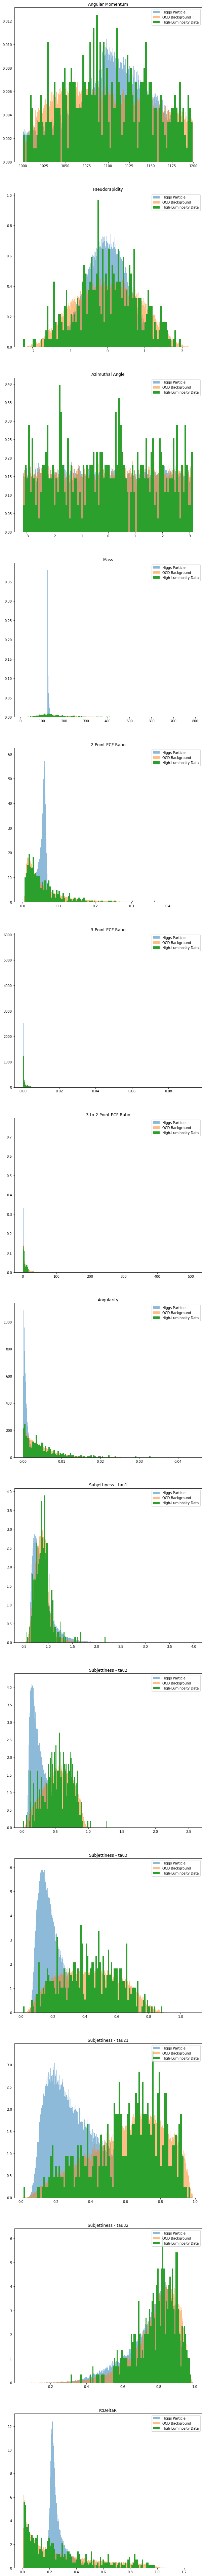

In [359]:
fig,ax=plt.subplots(14, 1, figsize=(10,140))

for i in range(0,14):
    ax[i].hist(
        higgs_qcd_stuff.get(features_list[i]).get('higgs_detail').get('data',""),
        500,
        alpha=.5,
        density=True,
        label=higgs_qcd_stuff.get(features_list[i]).get('higgs_detail').get('legend_label',""))
    # Creating a histogram of QCD data
    ax[i].hist(
        higgs_qcd_stuff.get(features_list[i]).get('qcd_detail').get('data',""),
        500,
        alpha=.5,
        density=True,
        label=higgs_qcd_stuff.get(features_list[i]).get('qcd_detail').get('legend_label',""))
    ax[i].hist(lowLum[:,i],
        bins=100,
        density=True,
        label="High-Luminosity Data" )
    # Setting graph details that are not sensitive to data source
    ax[i].set_title(higgs_qcd_stuff.get(features_list[i]).get('title',''))  
    ax[i].legend(loc='upper right')
    
plt.show()

### Optimizing the Data
I will now go through and follow the same process as before:  
* Find the indexes between the values that we want to keep  
    * Angularity: 0-.003
    * Tau21 Subjettiness: 0-.7
    * Mass: 124-128
* Make unique lists of those indexes  
* Remove keep desired values at those indexes; remove all others 
* Plot, find significance

### Finding the Significance
We will once again assume a Poisson distribution much like we did in Lab 7.   
We cannot use $\frac{N_{higgs}}{\sqrt{N_{QCD}}}$, however. The data we are using this time is not split between the background and the signal, so we do not know what NHiggs and NQCD are.  
We will use the mass data, with all cuts applied, find the mean, and calculate the significance from that. 

### Finding the Desired Indexes:

In [357]:
# Get the data for the features we want
ll_mass_feature_raw = lowLum[:,3]
ll_tau21_feature_raw = lowLum[:,11]
ll_ang_feature_raw = lowLum[:,7]

# Select the indexes we want to keep 
ll_mass_indexes = select_indexes(124,128,ll_mass_feature_raw)

# Optimize all on mass first
ll_tau21_feature_optimized = []
ll_ang_feature_optimized = []
for ind in ll_mass_indexes:
    ll_tau21_feature_optimized.append(ll_tau21_feature_raw[ind])
    ll_ang_feature_optimized.append(ll_ang_feature_raw[ind])

# Get indexes of remaining features we want to keep 
ll_anularity_indexes = select_indexes(0,.003,ll_ang_feature_optimized)
ll_tau_indexes = select_indexes(0,.7,ll_tau21_feature_optimized) 

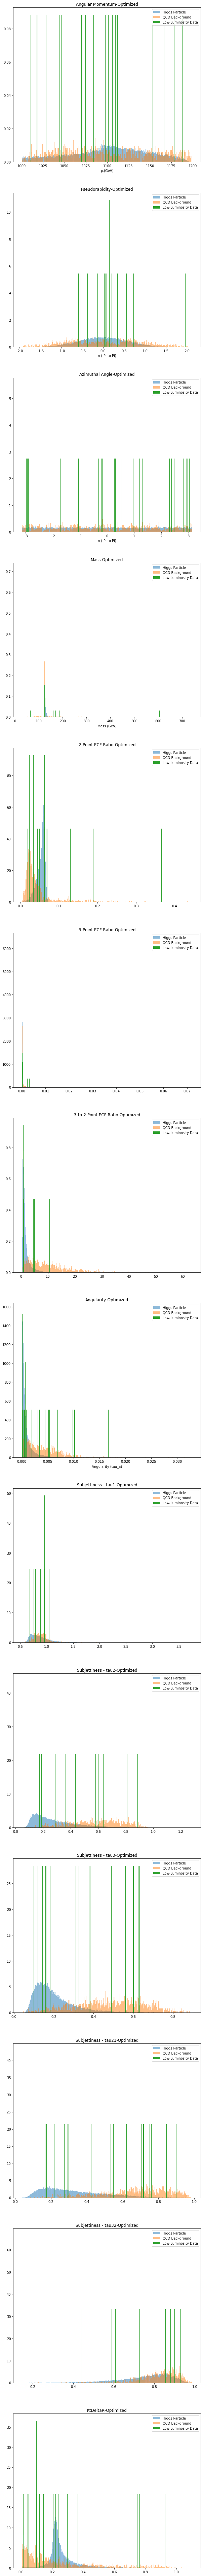

In [358]:
fig,ax=plt.subplots(14, 1, figsize=(10,140))

for k in range(0,14):
    ll_optimized_fin = []
    for l in ll_unique_indexes:
        ll_optimized_fin.append(lowLum[:,k][l])
    
    qcd_optimized_fin = []
    for m in qcd_unique_indexes:
        qcd_optimized_fin.append((higgs_qcd_stuff.get(features_list[k]).get('qcd_detail').get('data',""))[m])
        
    higgs_optimized_fin = []
    for n in higgs_unique_indexes:
        higgs_optimized_fin.append((higgs_qcd_stuff.get(features_list[k]).get('higgs_detail').get('data',""))[n])
        
    # Creating a histogram of Higgs data 
    ax[k].hist(
        higgs_optimized_fin,
        500,
        alpha=.5,
        density=True,
        label=higgs_qcd_stuff.get(features_list[k]).get('higgs_detail').get('legend_label','')) 
    # Creating a histogram of QCD data
    ax[k].hist(
        qcd_optimized_fin,
        500,
        alpha=.5,
        density=True,
        label=higgs_qcd_stuff.get(features_list[k]).get('qcd_detail').get('legend_label',''))  
    # Creating a histogram of Observed data
    ax[k].hist(
        ll_optimized_fin,
        500,
        density=True,
        label="Low-Luminosity Data"
        )  

    ax[k].set_title(f"{higgs_qcd_stuff.get(features_list[k]).get('title','')}-Optimized")  
    ax[k].set_xlabel(higgs_qcd_stuff.get(features_list[k]).get('xlabel',''))
    ax[k].legend(loc='upper right')
    
plt.show() 

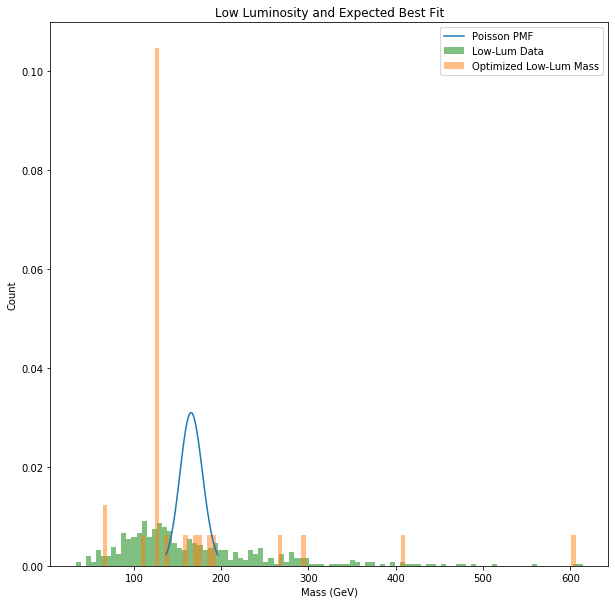

In [363]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

# Make Poisson representation with the mean of our background data
ll_optimized_mass_2 = []
for j in ll_unique_indexes:
    ll_optimized_mass_2.append(lowLum[:,3][j])
qcdMu = np.mean(ll_optimized_mass_2)
x = np.arange(stats.poisson.ppf(0.01, mu=qcdMu),stats.poisson.ppf(0.99, mu=qcdMu))
# Prepare the best-fit distribution
ax.plot(
    x, 
    stats.poisson.pmf(x, mu=qcdMu), 
    ms=4,
    label='Poisson PMF')

# Prepare background data
ax.hist(lowLum[:,3],
        bins=100,
        color='green',
        alpha=0.5, 
        label='Low-Lum Data', 
        density=True)
ax.hist(ll_optimized_mass_2,
       bins=100,
       alpha=.5,
       label="Optimized Low-Lum Mass",
       density=True)
# Set graph details
ax.legend(loc='upper right')
ax.set_title("Low Luminosity and Expected Best Fit")
ax.set_ylabel("Count")
ax.set_xlabel("Mass (GeV)")

plt.show()

In [366]:
cdf_mean = stats.poisson.cdf(qcdMu,mu=125)
sig_mean = stats.norm.ppf(cdf_mean)

print(f"Significance: {sig_mean}")

Significance: 3.5447687549913858


### Conclusion
Significance with cuts: 3.54   
Expected significance: 3.7 

The significance is very close to expected; just a little lower than the expected value. Note, however that is was nowhere near the almost-5$\sigma$ significance as was gathered in the High-luminosity data.  

Initially I had suspected that the jump in significance was due to the fact that there were far fewer data to work with, and removing just a few background data from the equation would make a large difference. However, because the Low-Luminosity data has even less data, I can no longer say that is the reason. Unless there is some threshold of number of data where, if we applied a certain cut to some dataset with many data, it would not apply the same way due to the vast difference in size of dataset.

## 95% Confidence Level Upper Limit

We will calculate the expected 5$\sigma$ significance and the Low-Luminosity observed 5$\sigma$ significance.  

In [411]:
cdf_mean = stats.poisson.cdf(np.mean(lowLum[:,3]),mu=246)
print(stats.norm.ppf(cdf_mean))

cdf_fin = stats.poisson.cdf(151.96,mu=222)
print(stats.norm.ppf(cdf_fin))


print(f"Expected 5-Sigma Signal: 222")
print(f"Observed 5-Sigma Signal: 246")

-5.015007706580816
-5.010679391038564
Expected 5-Sigma Signal: 222
Observed 5-Sigma Signal: 246


In the above, we look at the Low-Luminosity data (Observed), and the datasets we worked with in Lab 7 (Expected). 

The 5-Sigma Signals are not the same for the two datasets.  

It is interesting that we spent the majority of these two labs trying to perfect some threshold cuts on 'model' data, and applying it to our observed data to try and find a signal we suspected was there. Now we have come to this point, forcing a 5$\sigma$ signal on two different datasets, one that we tried to model after the other, only to find that the signals are pretty far from each other. 

So, we could go on to continue optimizing our model data to be able to better find signals in something like a Low-Luminosity dataset, so that when we did make cuts on our expected data, we would get better results out of our observed data. 

However, one could argue that you might model too closely to the observed data and not be able to use the model for any other situation. It's clear that if you were to model something after the high-luminosity data, you would NOT get the same results if applied to the low-luminosity data. 

So in the end, you have to find a sweet spot between being too specific for one type of event, and not being specific enough that, when you use your model on real data, your values (like a 5-$\sigma$ signal) are too different than your observed signal and you miss what you intended to look for. 